# **Redes Neurais Artificiais**

Exemplo de uma MLP (Multi-Layer Perceptron):

<img src="https://github.com/OviedoVR/ML_especializacao/blob/main/assets/ann_mlp_illustration.png?raw=true" width="70%"/>

Fonte: ELGENDY, Mohamed. **Deep Learning for Vision Systems**. Shelter Island: Manning Publications, 2020

<br>

> **PROBLEMA DE NEGÓCIO:** uma empresa de cursos preparatórios busca prever a performance de seus estudantes em um exame de certificação e, com isso, propor ações e estratégias para promover uma maior taxa de aprovação. Para isso, tem-se dados históricos contendo `horas de estudo`, `horas de sono`, `atividades extracurriculares (s/n)`, `número de questões praticadas`, `notas anteriores` e `nota final (performance)`.

In [102]:
# -- Manipulação de dados:
import pandas as pd

# -- DataViz:
import matplotlib.pyplot as plt
import seaborn as sns

# -- Pré-processamento:
from sklearn.model_selection import train_test_split

# RNA:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

> **Cálculo do RMSE (não é built-in no keras):**

In [103]:
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## **Coleta de dados e EDA**

In [104]:
!wget -q 'https://raw.githubusercontent.com/OviedoVR/ML_especializacao/main/dados/student_performance.csv' -O 'student_performance.csv'

In [105]:
# dados:
dados = pd.read_csv('student_performance.csv')
dados.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [106]:
# tamanho do dataset:
dados.shape

(10000, 6)

In [107]:
# amostra:
dados = dados.sample(n=3000, random_state=42)
dados.shape

(3000, 6)

In [108]:
# tipos de dado:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 6252 to 4705
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     3000 non-null   int64  
 1   Previous Scores                   3000 non-null   int64  
 2   Extracurricular Activities        3000 non-null   object 
 3   Sleep Hours                       3000 non-null   int64  
 4   Sample Question Papers Practiced  3000 non-null   int64  
 5   Performance Index                 3000 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 164.1+ KB


<Axes: >

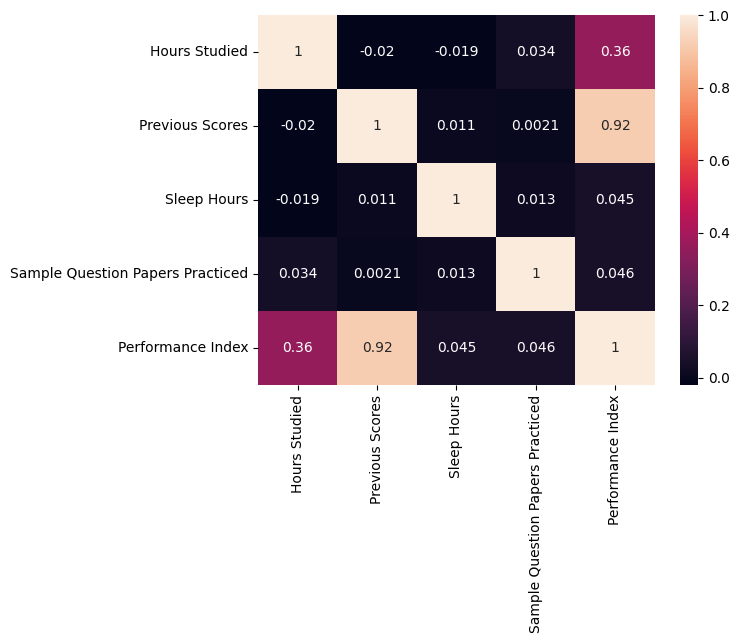

In [109]:
# Matriz de correlação:
dados_col_numericas = dados.select_dtypes(include='number')
sns.heatmap(dados_col_numericas.corr(), annot=True)

Comentário:

* A coluna `Sample Question Papers Practiced` parece ter uma correlação fraca com a resposta (`Performance Index`), logo, iremos retirá-la da análise.

## **Modelagem: Regressão**

In [110]:
# ordem das colunas:
dados = dados[[
    'Hours Studied',
    'Sleep Hours',
    'Extracurricular Activities',
    'Previous Scores',
    'Performance Index'
]]

In [111]:
# codificação de variáveis categóricas:
dados['Extracurricular Activities'] = dados['Extracurricular Activities'].replace('No', 0).replace('Yes', 1)

# normalização (variáveis numéricas contínuas):
# ----------------------------------------------------------------------------------------------------------------------------------------
dados['Hours Studied'] = dados['Hours Studied'].apply(
    lambda registro: (registro - dados['Hours Studied'].mean())/dados['Hours Studied'].std()
)
# ----------------------------------------------------------------------------------------------------------------------------------------
dados['Sleep Hours'] = dados['Sleep Hours'].apply(
    lambda registro: (registro - dados['Sleep Hours'].mean())/dados['Sleep Hours'].std()
)
# ----------------------------------------------------------------------------------------------------------------------------------------
dados['Previous Scores'] = dados['Previous Scores'].apply(
    lambda registro: (registro - dados['Previous Scores'].mean())/dados['Previous Scores'].std()
)
# ----------------------------------------------------------------------------------------------------------------------------------------

# Resultado:
dados.head()

<ipython-input-111-803915675c53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['Extracurricular Activities'] = dados['Extracurricular Activities'].replace('No', 0).replace('Yes', 1)


,Hours Studied,Sleep Hours,Extracurricular Activities,Previous Scores,Performance Index
6252,-0.004794,0.883327,0,-0.004593,51.0
4684,-1.170860,-1.478509,1,-1.330476,20.0
1731,0.772584,0.292868,1,-0.754005,46.0
4742,0.383895,0.883327,1,-1.561065,28.0
4521,0.772584,-1.478509,0,-0.926947,41.0


In [112]:
# Variáveis de entrada:
x = dados.drop('Performance Index', axis=1)
y = dados['Performance Index']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3,random_state=42)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(2100, 4)
(900, 4)
(2100,)
(900,)


In [113]:
# Criação do modelo (4 variáveis na camada de entrada, 1 camada oculta com 6 neurônios, 1 neurônio na camada de saída):
model = Sequential()
model.add(Dense(6, input_dim=4, activation='relu', kernel_initializer='uniform'))
model.add(Dense(1))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 6)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Compilação do modelo
model.compile(optimizer='SGD', loss='mse', metrics=['mse', rmse])

# Definição do EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=0, restore_best_weights=True)

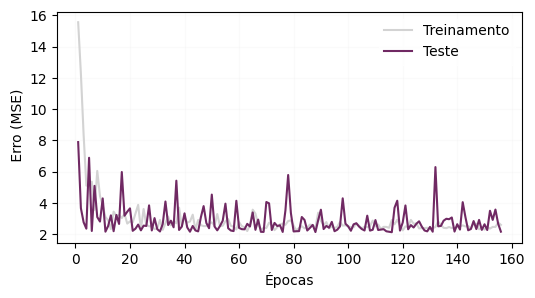

In [115]:
# Treinamento do modelo com EarlyStopping
historia = model.fit(xtrain, ytrain, epochs=200, batch_size=32, validation_data=(xtest, ytest), callbacks=[early_stopping], verbose=0)

# Obtenção do número de épocas treinadas
epochs = range(1, len(historia.history['mse']) + 1)

# Criação do gráfico
plt.figure(figsize=(6, 3))
plt.plot(epochs, historia.history['rmse'], label='Treinamento', color='lightgray')
plt.plot(epochs, historia.history['val_rmse'], label='Teste', color='#702963')
plt.xlabel('Épocas')
plt.ylabel(' Erro (MSE)')
plt.legend(edgecolor='white')
plt.grid(alpha=0.05)

In [116]:
# Avaliação do modelo e cálculo de R²
train_predictions = model.predict(xtrain)
train_r2 = round( r2_score(ytrain, train_predictions), 2)
test_predictions = model.predict(xtest)
test_r2 = round( r2_score(ytest, test_predictions), 2)

# Imprima os resultados
print('')
print('Batch Size: 32')
print(f'Train R²: {train_r2}, Test R²: {test_r2}')
print(f'Last MSE: {historia.history["mse"][-1]}, Last Val MSE: {historia.history["val_mse"][-1]}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Batch Size: 32
Train R²: 0.99, Test R²: 0.99
Last MSE: 7.126165390014648, Last Val MSE: 4.709414482116699


In [117]:
# Armazenar o histórico de treinamento no dicionário
models_history = {}
model_name = f'sequential_{len(models_history) + 1}'
models_history[model_name] = historia.history

# Exibir os resultados para cada modelo
for model_name, history in models_history.items():
  print(f"Model: {model_name}")
  print(f"Last MSE: {history['rmse'][-1]}, Last Val MSE: {history['val_rmse'][-1]}")
  print("=" * 30)

Model: sequential_1
Last MSE: 2.6054396629333496, Last Val MSE: 2.1715598106384277


* Fazendo uma predição pontual:

In [118]:
print(f'Valores x\n{xtest.head(5)}')
print('---'*30)
print(f'Valores de y\n{ytest.head(5)}')

Valores x
      Hours Studied  Sleep Hours  Extracurricular Activities  Previous Scores
2697      -1.559549    -1.478509                           0        -1.561065
6871       1.549961    -0.297591                           0         1.494233
3487       0.383895    -0.888050                           0        -1.042241
92         0.772584     0.883327                           1        -0.119887
9537      -0.782171     0.883327                           1         0.168349
------------------------------------------------------------------------------------------
Valores de y
2697    18.0
6871    90.0
3487    38.0
92      60.0
9537    54.0
Name: Performance Index, dtype: float64


In [119]:
predicoes_5_linhas_teste = model.predict(xtest.head(5))

# Imprima os valores
for valor in predicoes_5_linhas_teste:
    print(valor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[17.480978]
[91.688286]
[37.95253]
[59.571777]
[53.46286]


## **Modelagem: Classificação**

In [120]:
# obtendo classes como resposta (1: aprovado, 0: reprovado):
dados['Performance Index'] = dados['Performance Index'].apply(lambda registro: 1 if registro >= 70 else 0)

# Variáveis de entrada:
x = dados.drop('Performance Index', axis=1)
y = dados['Performance Index']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3,random_state=42)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(2100, 4)
(900, 4)
(2100,)
(900,)


In [121]:
# Criação do modelo (4 variáveis na camada de entrada, 1 camada oculta com 6 neurônios, 1 neurônio na camada de saída):
model_class = Sequential()
model_class.add(Dense(6, input_dim=4, activation='relu'))
model_class.add(Dense(1, activation='sigmoid'))
model_class.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 6)                   │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

In [122]:
# Compilando o modelo
model_class.compile(loss='binary_crossentropy',  # Função de perda para classificação binária
              optimizer='adam',             # Otimizador Adam
              metrics=['accuracy'])         # Métrica de acurácia

# Definindo o EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               verbose=0,
                               restore_best_weights=True)

# Treinando o modelo
historia = model_class.fit(xtrain, ytrain,              # Dados de treinamento
                    epochs=200,                                     # Número máximo de épocas
                    batch_size=32,                                 # Tamanho do batch
                    validation_data=(xtest, ytest),         # Dados de validação
                    callbacks=[early_stopping],            # Callback EarlyStopping
                    verbose=0
)

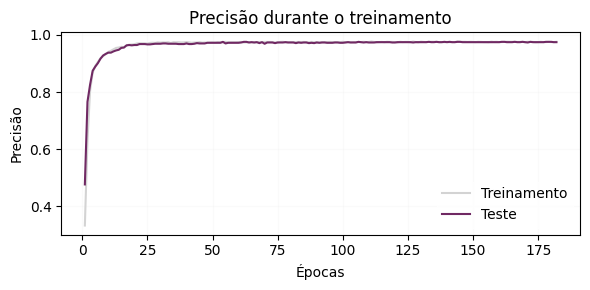

In [123]:
# Obtenção do número de épocas treinadas
epochs = range(1, len(historia.history['accuracy']) + 1)

# Plotando a precisão de treinamento e teste
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(epochs, historia.history['accuracy'], label='Treinamento', color='lightgray')
plt.plot(epochs, historia.history['val_accuracy'], label='Teste', color='#702963')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.title('Precisão durante o treinamento')
plt.legend(edgecolor='white')
plt.grid(alpha=0.05)
plt.tight_layout()

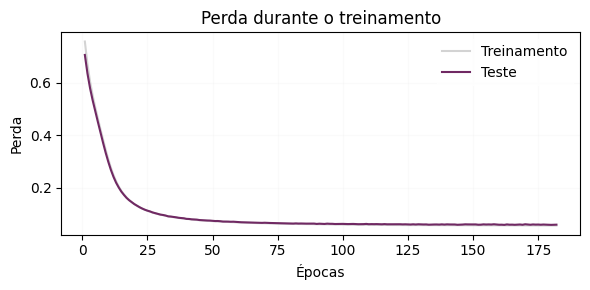

In [124]:
# Plotando a perda (loss) de treinamento e teste
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(epochs, historia.history['loss'], label='Treinamento', color='lightgray')
plt.plot(epochs, historia.history['val_loss'], label='Teste', color='#702963')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Perda durante o treinamento')
plt.legend(edgecolor='white')
plt.grid(alpha=0.05)
plt.tight_layout();

In [125]:
from sklearn.metrics import accuracy_score

# Predições do modelo
train_predictions = model_class.predict(xtrain)
test_predictions = model_class.predict(xtest)

# Converter as predições para binário (0 ou 1) se necessário
train_predictions_binary = (train_predictions > 0.5).astype(int)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Avaliar o modelo
train_accuracy = round(accuracy_score(ytrain, train_predictions_binary), 2)
test_accuracy = round(accuracy_score(ytest, test_predictions_binary), 2)

# Imprimir resultados
print('')
print('Batch Size: 32')
print(f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')
print(f'Last Loss: {historia.history["loss"][-1]}, Last Val Loss: {historia.history["val_loss"][-1]}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Batch Size: 32
Train Accuracy: 0.98, Test Accuracy: 0.98
Last Loss: 0.05628196895122528, Last Val Loss: 0.059514470398426056


* Fazendo uma predição pontual:

In [126]:
print(f'Valores x\n{xtest.head(5)}')
print('---'*30)
print(f'Valores de y\n{ytest.head(5)}')

Valores x
      Hours Studied  Sleep Hours  Extracurricular Activities  Previous Scores
2697      -1.559549    -1.478509                           0        -1.561065
6871       1.549961    -0.297591                           0         1.494233
3487       0.383895    -0.888050                           0        -1.042241
92         0.772584     0.883327                           1        -0.119887
9537      -0.782171     0.883327                           1         0.168349
------------------------------------------------------------------------------------------
Valores de y
2697    0
6871    1
3487    0
92      0
9537    0
Name: Performance Index, dtype: int64


In [127]:
predicoes_5_linhas_teste = model_class.predict(xtest.head(5))

# Imprima os valores
print('Predições para as 5 primeiras linhas do conjunto de teste:')

for i, valor in enumerate(predicoes_5_linhas_teste):
    classe = 1 if valor >= 0.7 else 0
    print(f'Linha {i + 1}: {valor} - classe {classe}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predições para as 5 primeiras linhas do conjunto de teste:
Linha 1: [9.141504e-09] - classe 0
Linha 2: [0.9999998] - classe 1
Linha 3: [3.3086276e-06] - classe 0
Linha 4: [0.00030448] - classe 0
Linha 5: [5.992592e-06] - classe 0
